# <center>Neural Network - Comparison between Numpy and Spark</center>

This project is aimed at building the model of **Neural Network** by both Numpy and Spark implementations and then comparing their efficiency in each both small and large database. Our notebook will be developed in three aspects: recall of theoretical concepts about the Spark and Neural Network, the implementation in Python and the interpretation of results. 

The following code versions including tests of both version with Numpy and Spark implementations with 2 databases.

## Part 1. Several basic notations

### 1.1. Introduction of Spark

Spark uses Resilient Distributed Datasets (RDD) as its fundamental data structure. 
Each dataset in RDD is divided into logical partitions, which may be computed on different nodes of the cluster. 
Spark has a functional programming API in multiple languages, providing many operators like `map` and `reduce`. 

Spark is particularly effective for iterative problems where data can be reused throughout the entire algorithmic operation. 
Most machine learning and optimization algorithms are iterative, making Spark a very effective tool for data science. 

To develop a program using Spark, we follow the steps as:
1. Define one or some RDDs. You can obtain data stored on disk (HDFS, Cassandra, HBase, Local Disk), parallelize certain collections in memory, transform an existing RDD, or cache save.
2. Operations on the RDD are realized by passing a closure (function) to each element on the RDD.
3. Actions (such as count, collect, save, etc.) that use the resulting RDD. The action will start the computation on the cluster.

### 1.2. Neural Network model 

We build  two systems to construct the general neutral network( `utils.py` file for numpy implementation and codes in cells for spark implementation ) :
1. Define a neural network structure(function: `layer_sizes()`) which contains the size of input/hidden/output layer.
2. Initialize the model’s parameters using `np.random()` (function: `initialize_parameter()`).
3. Update parameters using loop: 
    i)   Forward propagation.
    ii)  Compute loss .
    iii) Backward propagation to get the gradients .
    iv) Update parameters using gradient descent method.

## Part 2. Code 

In [1]:
import findspark
findspark.init("D:/Code/Spark/spark-2.3.2-bin-hadoop2.7")

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

In [2]:
import pandas as pd
import numpy as np
import time
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from operator import add
from tqdm import tqdm
plt.style.use('ggplot')
%matplotlib inline

In [3]:
# create a SparkContext object, which tells Spark how to access a cluster
spark = SparkSession.builder.appName("PythonNN").getOrCreate()

## 2.1. Test on small dataset

In [4]:
X, Y = load_planar_dataset()

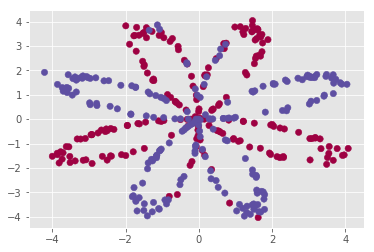

In [5]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral)

### 2.1.1. Numpy implementation for training

In [6]:
# Build a model with a n_h = 5-dimensional hidden layer
start_time = time.time()
parameters = nn_model(X, Y, n_h = 5, lr = 1.2, num_iterations = 1000, print_cost=True)
end_time = time.time()

Cost after iteration 0: 0.693252
Cost after iteration 100: 0.398793
Cost after iteration 200: 0.326642
Cost after iteration 300: 0.311232
Cost after iteration 400: 0.303132
Cost after iteration 500: 0.297815
Cost after iteration 600: 0.293874
Cost after iteration 700: 0.290725
Cost after iteration 800: 0.288084
Cost after iteration 900: 0.285797


In [7]:
print(f"It takes {end_time - start_time:.4f}s")

It takes 0.2161s


First of all, we consider the model of Neural Network with the Numpy implementation. In this case, the dataset is loaded directly on RAM and each calculation of Numpy NN gradient iteration is calculated by computer core without re-loading data. And the following part, we will consider the same model built by Spark with the same data set. 

### 2.1.2. Spark implementation

PySpark can create distributed datasets from any storage source supported by Hadoop, including your local file system, HDFS, Cassandra, HBase, Amazon S3, etc. Spark supports text files, SequenceFiles, and any other Hadoop InputFormat. That's reason why, the dataset used in the previous example was transformed into txt file in order to support the Spark in reading text function (data is loaded from local machine by Spark via text file with format txt).


In [8]:
# Dimension of database
D = 2

In [9]:
def readPointBatch(iterator):
    strs = list(iterator)
    matrix = np.zeros((len(strs), D + 1))
    for i, s in enumerate(strs):
        matrix[i] = np.fromstring(s.replace(',', ' '), dtype=np.float32, sep=' ')
    return [matrix]

In [10]:
# Load dataset but do not compute their results right away. 
points = spark.read.text('planar_data.txt').rdd.map(lambda r: r[0]).mapPartitions(readPointBatch).cache()

In [11]:
# number of elements partitioned across the nodes of the cluster that can be operated on in parallel
points.getNumPartitions()

1

**Note:** Data is processed only on 1 node in parallel

In [12]:
parameters = initialize_parameters(n_x = 2, n_h = 5, n_y = 1)

In [13]:
def gradient(matrix, parameters):
    Y = matrix[:, 0].T.reshape(1, -1)    # point labels (first column of input file)
    X = matrix[:, 1:].T   # point coordinates
    m = X.shape[1]
    
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = W1.dot(X) + b1
    A1 = np.tanh(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)   
    
    # Compute cost
    cost = (-1/m*(Y.dot(np.log(A2.T)) + (1 - Y).dot(np.log(1 - A2.T))))[0, 0]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = 1/m*dZ2.dot(A1.T)
    db2 = 1/m*np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = W2.T.dot(dZ2)*(1 - A1**2)
    dW1 = 1/m*dZ1.dot(X.T)
    db1 = 1/m*np.sum(dZ1, axis = 1, keepdims = True)
    
    return cost, dW2, db2, dW1, db1

In [14]:
start_time = time.time()
for i in range(1000):
    cost, dW2, db2, dW1, db1 = points.map(lambda m: gradient(m, parameters)).reduce(lambda x, y: tuple(map(sum, zip(x, y))))
    
    parameters['W2'] -= 1.2*dW2
    parameters['b2'] -= 1.2*db2
    parameters['W1'] -= 1.2*dW1
    parameters['b1'] -= 1.2*db1
         
    if i % 100 == 0:
        print (f"Cost after iteration {i}: {cost / points.getNumPartitions():.4f}")
end_time = time.time()

Cost after iteration 0: 0.6933
Cost after iteration 100: 0.3988
Cost after iteration 200: 0.3266
Cost after iteration 300: 0.3112
Cost after iteration 400: 0.3031
Cost after iteration 500: 0.2978
Cost after iteration 600: 0.2939
Cost after iteration 700: 0.2907
Cost after iteration 800: 0.2881
Cost after iteration 900: 0.2858


In [15]:
print(f"It takes {end_time - start_time:.4f}s")

It takes 1027.6913s


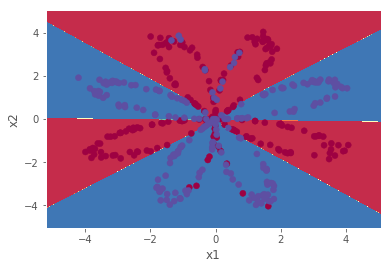

In [16]:
# Visualize results of classification by decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

### 2.1.3. Comment


    
As can be seen on the results turned out by both numpy and spark implementations, the results are exactly the same. However, the calculation time in Spark takes much longer comparing with the Numpy version. This can be explained by the Spark's laziness.

While in Numpy version, all dataset is loaded and stocked once on RAM right on the command `load_planar_dataset()` and each calculation is taken directly on RAM without reloading and re-stocking. 

On the other hand, in Spark implementation, it does not compute the results right away. Instead, it just remembers the transformations applied to some base dataset. The transformations are only computed when an action requires a result to be returned to the driver program. This design enables Spark to run more efficiently. For example, we can realize that a dataset created through map will be used in a reduce and return only the result of the reduce to the driver, rather than the larger mapped dataset. Therefore, in this version, the calculation time take much longer (more than 500 seconds) than the previous one (less than 1 second), while the dataset is reloaded in each iteration. 

## 2.2. Test on bigger dataset


In the previous example of small dataset, both Numpy and Spark version of Neural Network model give the same result even the calculation time is much different. And in this part, we reconsider both versions with larger database and re-examine their efficiency, their advantages and disadvantages.


The dataset employ
ed here comes from an old Kaggle competition in famous Dogs and Cats binary classification problem. The source is available here https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition. As a problem of Dogs vs Cats classification, all raw datasets loaded from Kaggle platform are stored in picture formats (jpeg or png formats) so in order to simplify the loading in spark, several steps of pre-processing database are taken including loading images, resizing into dimention of 32x32x3, reshaping into (32x32x3, )) and then converting into text format (txt).

### 2.2.1. Numpy implementation

In [17]:
# Need to load dataset for numpy implementation
with open('cat_dog.txt', mode = 'r') as f:
    data = f.read().split('\n')

In [18]:
# Need to load dataset for numpy implementation
labels = []
features = []
for d in tqdm(data):
    labels.append(int(d.split()[0]))
    features.append([float(f) for f in d.split()[1:]])

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:46<00:00, 533.86it/s]


In [19]:
# Transform to ndarray format
np.random.seed(1234)
idx = np.random.permutation(range(len(labels)))
features = np.array(features)[idx]
labels = np.array(labels)[idx]

In [20]:
labels

array([1, 0, 1, ..., 0, 0, 1])

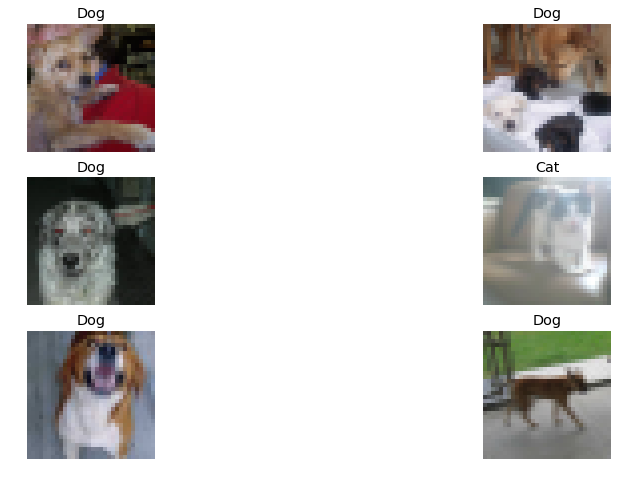

In [21]:
# Plot some examples
fig, ax = plt.subplots(3, 2, figsize = (15, 8))
ax = ax.ravel()
for i in range(6):
    idx = np.random.randint(len(labels))
    label = "Cat" if labels[idx] == 1 else "Dog"
    ax[i].imshow(features[idx].reshape(32, 32, 3)[:,:,::-1])
    ax[i].set_title(f"{label}")
    ax[i].axis('off')  

In [22]:
# Build a model with a n_h = 64-dimensional hidden layer
start_time = time.time()
parameters = nn_model(features.T, labels.reshape(1, -1), n_h = 64, lr = 0.1, num_iterations = 1000, print_cost=True)
end_time = time.time()

Cost after iteration 0: 0.693260
Cost after iteration 100: 0.682132
Cost after iteration 200: 0.669947
Cost after iteration 300: 0.666670
Cost after iteration 400: 0.666218
Cost after iteration 500: 0.658732
Cost after iteration 600: 0.653991
Cost after iteration 700: 0.650241
Cost after iteration 800: 0.646952
Cost after iteration 900: 0.643967


In [23]:
end_time - start_time

244.6782042980194

### 2.2.2. Spark implementation

In [24]:
D = 32*32*3

In [25]:
points = spark.read.text('cat_dog.txt').rdd.map(lambda r: r[0]).mapPartitions(readPointBatch).cache()

In [26]:
# number of elements partitioned across the nodes of the cluster that can be operated on in parallel
num_partitions = points.getNumPartitions()

In [27]:
print(f"Data is processed on {num_partitions} nodes in parallel")

Data is processed on 11 nodes in parallel


In [28]:
parameters = initialize_parameters(n_x = 32*32*3, n_h = 64, n_y = 1)

In [29]:
for i in range(15):
    cost, dW2, db2, dW1, db1 = points.map(lambda m: gradient(m, parameters)).reduce(lambda x, y: tuple(map(lambda x: sum(x) / len(x), zip(x, y))))
    
    parameters['W2'] -= 0.1*dW2
    parameters['b2'] -= 0.1*db2
    parameters['W1'] -= 0.1*dW1
    parameters['b1'] -= 0.1*db1
         
    if i % 2 == 0:
        print (f"Cost after iteration {i + 1}: {cost:.4f}")

Cost after iteration 1: 0.6909
Cost after iteration 3: 0.3443
Cost after iteration 5: 0.1635
Cost after iteration 7: 0.1280
Cost after iteration 9: 0.1170
Cost after iteration 11: 0.1124
Cost after iteration 13: 0.1103
Cost after iteration 15: 0.1092


### 2.2.3. Comment 


As can be seen, even Spark takes much time in calculation as it need to map dataset in each node and then does calculation. However, it can execute various parallel operations on a cluster. The main abstraction Spark provides is a resilient distributed dataset (RDD), which is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel. And in this example of Dog-Cat database, Spark runs a function in parallel as a set of tasks on total 11 nodes, it ships a copy of each variable used in the function to each task. This allows to avoid the problem of running out of memory.

Furthermore, it's obvious that we do just 15 iterations but actually, Spark has been calculated 15 x 11 = 165 gradient iterations and then taken mean each 11 gradient iteration and finally updated the parameters. This allow to avoid the problem of divergence (see more on graph below).

<img src="optimizer.png" style="width:650px;height:400px;">

# Part 3. Conclusion 

In conclusion, this seems that Spark do not appropriate in building several complex models such as Neural Network while all dataset (generally, in large dataset in Big Data) is divided in several nodes. This leads to bias results in gradient calculations (Spark calculates gradients in each note and then takes the mean of all calculated gradients in all nodes, the turned out result is denoted as the gradient of all dataset and this result is bias). So the result of complex model like Neural Network may turn also bias.

On the other hand, with some problem with simple commands such as `count`, `sum` or `aggregate`, etc, Spark can perform much better while all dataset will be independent in these calculation. That's reason why Spark is appropriate in Data analysis in Big Data (greate choice for dealing with structured database), but it's not competitive comparing to pandas or numpy when running a single process on a single machine. One reason is that Spark is designed to distribute processing across hundreds of nodes. It must ensure correctness and fault tolerance which costs significantly.

So for small dataset, parallelism add significant overhead cost without guarantee of an improvement of performance. So it's better to use numpy for small dataset.